**Libraries, Functions, Import Files**

In [ ]:
!pip install shap
!pip install catboost
!pip install bayesian-optimization optuna
!pip install scikit-learn scikit-optimize

In [2]:
#Import libraries
import shap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError

import optuna
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from bayes_opt import BayesianOptimization, UtilityFunction

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
def Shap(model):
  explainer = shap.Explainer(model)
  shap_values = explainer.shap_values(X)
  return shap.summary_plot(shap_values,X)

In [4]:
def metrics(model,model_name):
  R2_test = r2_score(y_test, model.predict(X_test))
  R2_train = r2_score(y_train, model.predict(X_train))
  mse_test = mean_squared_error(y_test, model.predict(X_test))
  mse_train = mean_squared_error(y_train, model.predict(X_train))
  mae_test = mean_absolute_error(y_test, model.predict(X_test))
  mae_train = mean_absolute_error(y_train, model.predict(X_train))
  rmse_test = np.sqrt(np.mean((y_test - model.predict(X_test)) ** 2))
  rmse_train = np.sqrt(np.mean((y_train - model.predict(X_train)) ** 2))

  metrics = pd.DataFrame({
    'R2_test': R2_test,
    'R2_train': R2_train,
    'mse_test': mse_test,
    'mse_train': mse_train,
    'rmse_test': rmse_test,
    'rmse_train': rmse_train}, index=[model_name])
  return metrics

In [5]:
def cross_validation(n_splits,random_state,model):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
  print(f"Cross-validated R2(Train): {cv_scores.mean()}")

In [6]:
def adjusted_r2(model):
  adjusted_r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
  print("Adjusted_R2:",adjusted_r2)
  adjusted_r2_train = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
  print("Adjusted_R2_train:",adjusted_r2_train)
  adjusted_r2_test = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
  print("Adjusted_R2_test:",adjusted_r2_test)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving data_paper1.xlsx to data_paper1.xlsx


#XRD

In [8]:
Paper1_XRD = pd.read_excel('/content/data_paper1.xlsx',sheet_name='XRD')
X = Paper1_XRD.drop('delta(eff)', axis=1)
y = Paper1_XRD['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

##Models

###XGBRegressor

In [9]:
#Optimization_XGBoost_Regressor
def objective(learning_rate,n_estimators,reg_lambda,alpha):
    model = XGBRegressor(learning_rate=learning_rate,
                         n_estimators=int(n_estimators),
                         reg_lambda = reg_lambda,
                         alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)
#===============================================================================
pbounds = {
    'learning_rate': (0.02, 0.045),
    'n_estimators': (300, 500),
    'reg_lambda' : (0.1,1),
    'alpha': (0,0.8)
}
#===============================================================================
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=78,
)

optimizer.maximize(
    init_points=5,
    n_iter=30,
)

|   iter    |  target   |   alpha   | learni... | n_esti... | reg_la... |
-------------------------------------------------------------------------
| 1         | 0.942     | 0.03854   | 0.03702   | 459.7     | 0.8201    |
| 2         | 0.7349    | 0.7722    | 0.0311    | 466.2     | 0.3219    |
| 3         | 0.881     | 0.04022   | 0.03219   | 430.0     | 0.9289    |
| 4         | 0.7457    | 0.591     | 0.02619   | 403.6     | 0.6977    |
| 5         | 0.7924    | 0.2342    | 0.04184   | 476.6     | 0.6038    |
| 6         | 0.7862    | 0.4798    | 0.02778   | 374.7     | 0.9163    |
| 7         | 0.8051    | 0.2686    | 0.03359   | 456.4     | 0.7216    |
| 8         | 0.7898    | 0.2675    | 0.02841   | 407.6     | 0.5504    |
| 9         | 0.8467    | 0.1004    | 0.02327   | 346.8     | 0.8674    |
| 10        | 0.9622    | 0.03141   | 0.045     | 459.7     | 0.9446    |
| 11        | 0.8135    | 0.0       | 0.045     | 459.2     | 1.0       |
| 12        | 0.9579    | 0.02059   | 

In [10]:
model_XGB_XRD = XGBRegressor(alpha=0.02752, reg_lambda=0.9295, n_estimators=315, learning_rate= 0.04316)
model_XGB_XRD.fit(X_train, y_train);
XGB1 = metrics(model_XGB_XRD,'XGBoostRegressor')
XGB1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.960617,0.969028,0.019879,0.014695,0.140993,0.121221


In [15]:
cross_validation(3,78,model_XGB_XRD)

Cross-validated R2(Train): -0.1792906447500726


In [16]:
adjusted_r2(model_XGB_XRD)

Adjusted_R2: 0.8798550657390432
Adjusted_R2_train: 0.38056709005859357
Adjusted_R2_test: 1.0140653961661925


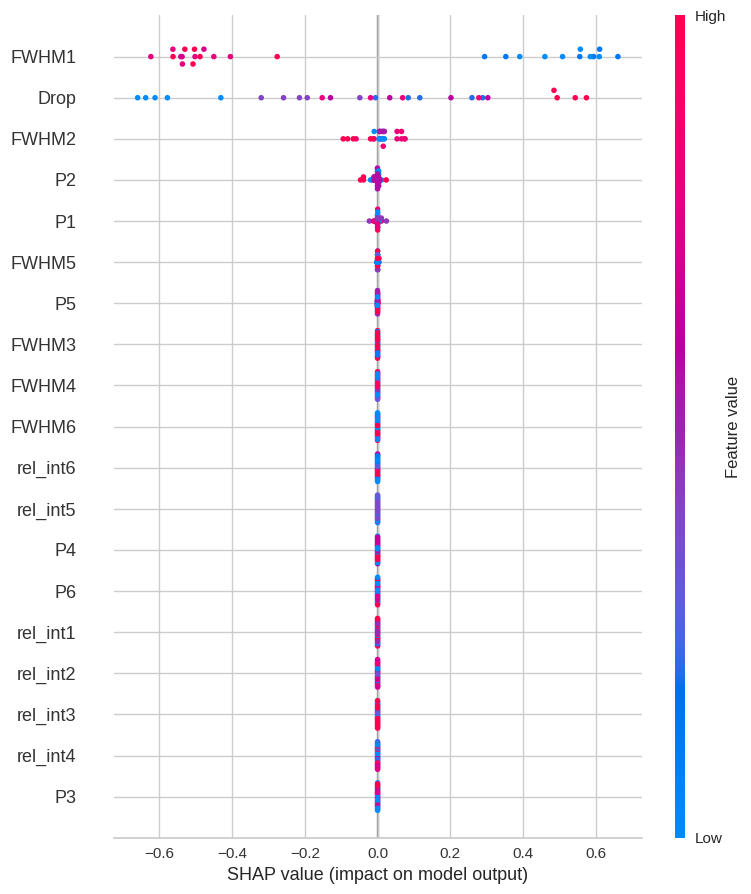

In [17]:
Shap(model_XGB_XRD)



---



---



[I 2024-07-06 22:59:22,227] A new study created in memory with name: no-name-0e58e9f3-0d3d-46b5-b938-9b6f079e2df8
[I 2024-07-06 22:59:22,487] Trial 0 finished with value: 0.3513334072258553 and parameters: {'alpha': 0.33027624954910717, 'reg_lambda': 0.8330801775708874, 'n_estimators': 325, 'learning_rate': 0.3718355776901494}. Best is trial 0 with value: 0.3513334072258553.
[I 2024-07-06 22:59:22,727] Trial 1 finished with value: 0.346490781083572 and parameters: {'alpha': 0.3553004932776321, 'reg_lambda': 0.8890852620846703, 'n_estimators': 345, 'learning_rate': 0.3173323579226989}. Best is trial 1 with value: 0.346490781083572.
[I 2024-07-06 22:59:22,971] Trial 2 finished with value: 0.33929921264252555 and parameters: {'alpha': 0.3917147042467184, 'reg_lambda': 0.8057532019007867, 'n_estimators': 366, 'learning_rate': 0.3352782308252368}. Best is trial 2 with value: 0.33929921264252555.
[I 2024-07-06 22:59:23,221] Trial 3 finished with value: 0.3551225523801693 and parameters: {'al

{'alpha': 0.3917147042467184, 'reg_lambda': 0.8057532019007867, 'n_estimators': 366, 'learning_rate': 0.3352782308252368}


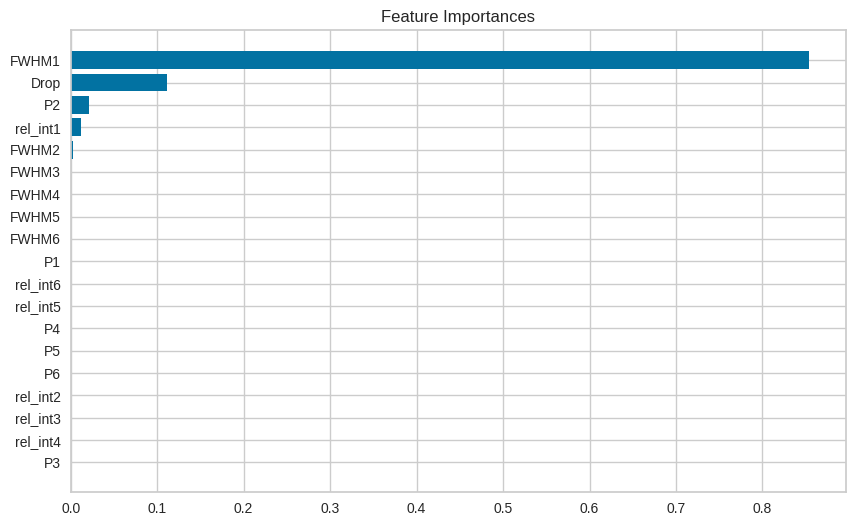

In [18]:
#optuna_XGBoostRegressor_changeable
def objective(trial):
  params = {
      'alpha': trial.suggest_float('alpha', 0.3, 0.4),
      'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 0.9),
      'n_estimators': trial.suggest_int('n_estimators', 300,500),
      'learning_rate': trial.suggest_float('learning_rate', 0.3, 0.4),
      }

  model = XGBRegressor(**params)
  kf = KFold(n_splits=3, shuffle=True, random_state=78)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
  return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

xgb_best_params = study.best_params
print(xgb_best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
xgb_XRD = XGBRegressor(**xgb_best_params)
xgb_XRD.fit(X_train, y_train)


#feature importances
feature_importances = xgb_XRD.feature_importances_
feature_names = X.columns.tolist()
indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [19]:
XGB2 = metrics(xgb_XRD,'XGBoostRegressor')
XGB2

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.819482,0.82777,0.091118,0.081715,0.301858,0.285858


In [20]:
cross_validation(3,78,xgb_XRD)

Cross-validated R2(Train): 0.16491900845428073


In [21]:
adjusted_r2(xgb_XRD)

Adjusted_R2: 0.3646180165208618
Adjusted_R2_train: -2.444595612194441
Adjusted_R2_test: 1.0644708150357332


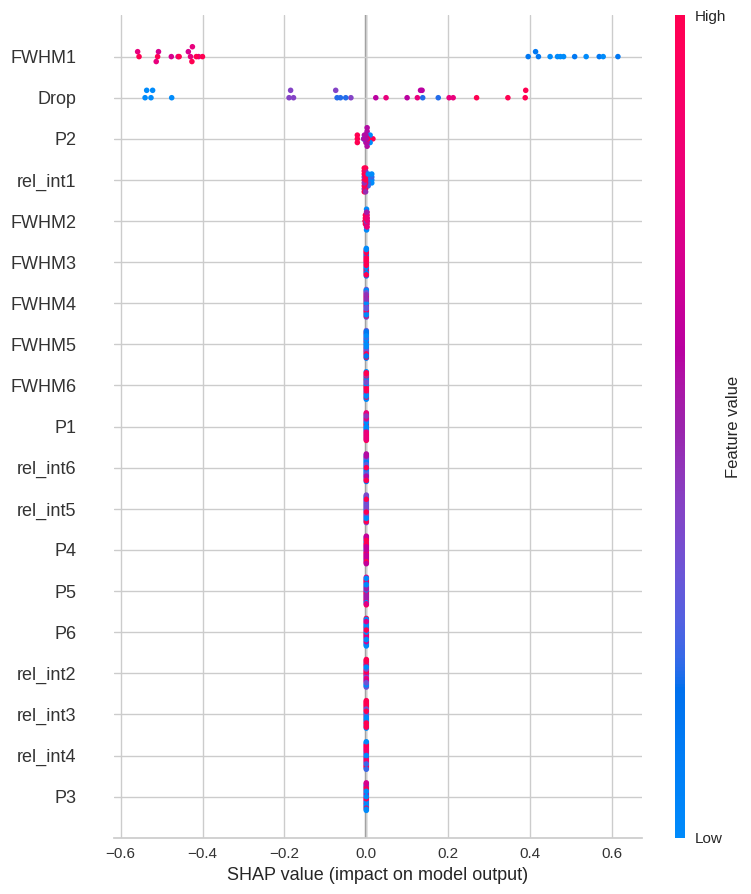

In [22]:
Shap(xgb_XRD)

###RandomForestRegressor

[I 2024-07-06 23:01:39,776] A new study created in memory with name: no-name-b0719e71-3ef6-4284-84c8-adf2a2f4d1ee
[I 2024-07-06 23:01:42,671] Trial 0 finished with value: 0.35197230509031474 and parameters: {'n_estimators': 778, 'max_depth': 8}. Best is trial 0 with value: 0.35197230509031474.
[I 2024-07-06 23:01:47,250] Trial 1 finished with value: 0.3519773354465004 and parameters: {'n_estimators': 863, 'max_depth': 7}. Best is trial 0 with value: 0.35197230509031474.
[I 2024-07-06 23:01:49,944] Trial 2 finished with value: 0.3445085856930071 and parameters: {'n_estimators': 721, 'max_depth': 9}. Best is trial 2 with value: 0.3445085856930071.
[I 2024-07-06 23:01:52,915] Trial 3 finished with value: 0.3502046730824839 and parameters: {'n_estimators': 823, 'max_depth': 10}. Best is trial 2 with value: 0.3445085856930071.
[I 2024-07-06 23:01:55,806] Trial 4 finished with value: 0.3522626101608979 and parameters: {'n_estimators': 803, 'max_depth': 8}. Best is trial 2 with value: 0.34450

Best hyperparameters: {'n_estimators': 721, 'max_depth': 9}


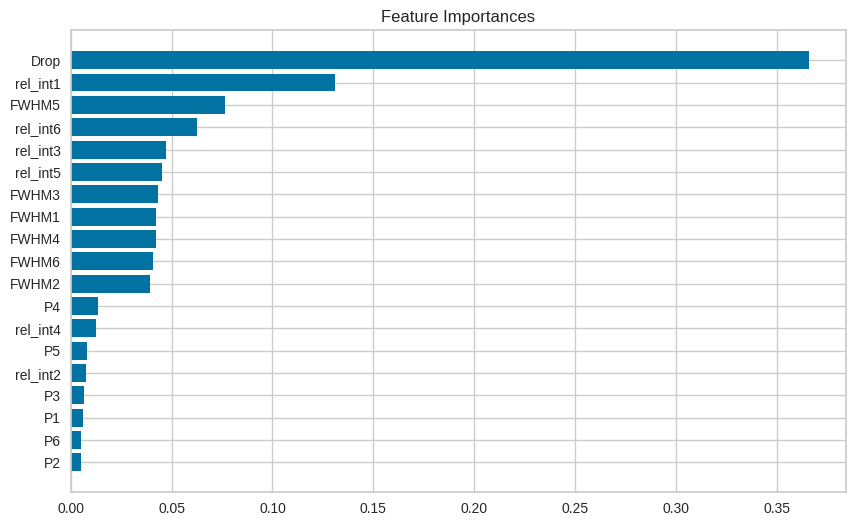

In [26]:
#optuna_RandomForestRegressor_changeable
def objective(trial):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 700,900),
      'max_depth': trial.suggest_int('max_depth', 7,10),
      }

  model = RandomForestRegressor(**params)
  kf = KFold(n_splits=3, shuffle=True, random_state=78)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
  return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

RF_best_params = study.best_params
print(f"Best hyperparameters: {RF_best_params}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
RF_XRD = RandomForestRegressor(**RF_best_params)
RF_XRD.fit(X_train, y_train)


#feature importances
feature_importances = RF_XRD.feature_importances_
feature_names = X.columns.tolist()
indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [27]:
RF1 = metrics(RF_XRD,'RandomForestregressor')
RF1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
RandomForestregressor,0.852709,0.895121,0.074347,0.04976,0.272666,0.22307


In [31]:
cross_validation(2,78,RF_XRD)

Cross-validated R2(Train): 0.10223801408231742


In [29]:
adjusted_r2(RF_XRD)

Adjusted_R2: 0.5813078171190894
Adjusted_R2_train: -1.0975879216607995
Adjusted_R2_test: 1.0526040526671119


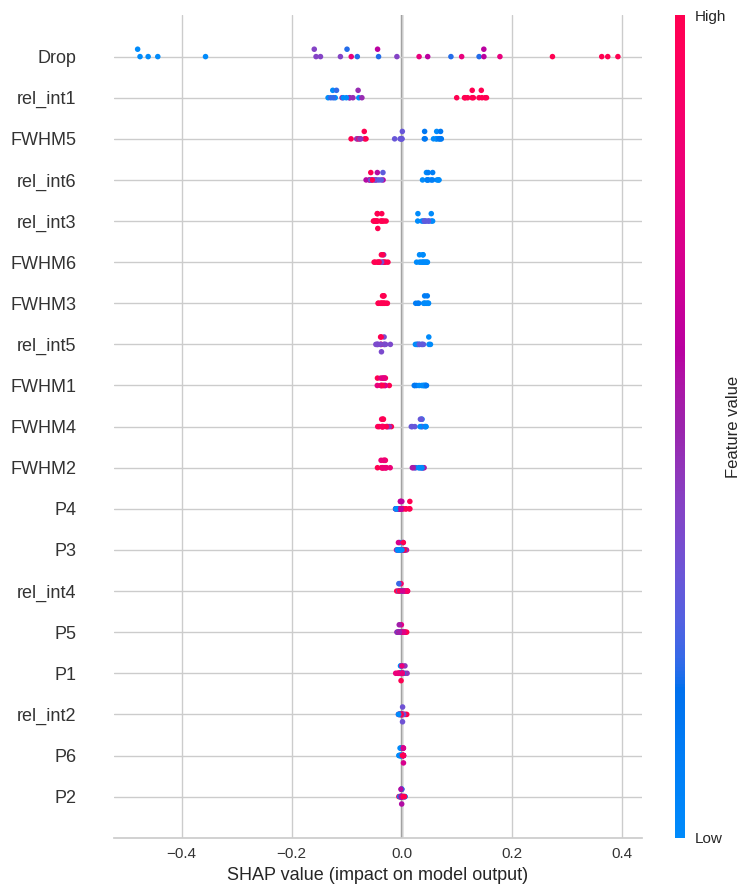

In [32]:
Shap(RF_XRD)

###CatBoostRegressor

In [33]:
model_Cat_XRD = CatBoostRegressor(iterations=172, depth=3, learning_rate=0.07545457620773927, l2_leaf_reg=3.0671713060927353,verbose=0)
model_Cat_XRD .fit(X_train, y_train);
Cat1 = metrics(model_Cat_XRD,'CatBoostRegressor')
Cat1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
CatBoostRegressor,0.850673,0.902093,0.075374,0.046452,0.274544,0.215527


In [36]:
cross_validation(3,78,model_Cat_XRD)

Cross-validated R2(Train): 0.1504775308250922


In [35]:
adjusted_r2(model_Cat_XRD)

Adjusted_R2: 0.5990847506313823
Adjusted_R2_train: -0.9581315415741751
Adjusted_R2_test: 1.0533312417062897


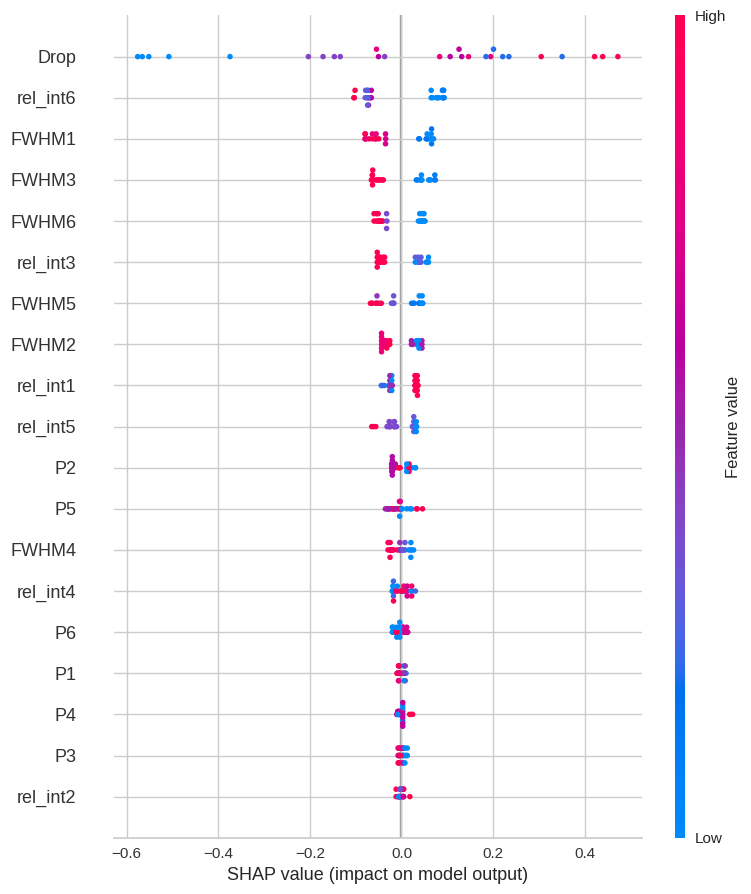

In [37]:
Shap(model_Cat_XRD)



---



---



[I 2024-07-06 23:04:30,333] A new study created in memory with name: no-name-b60ebf8b-4ac3-4bfc-81a2-72e57e999fd3
[I 2024-07-06 23:04:31,104] Trial 0 finished with value: 0.1794113306051888 and parameters: {'iterations': 445, 'depth': 5, 'learning_rate': 0.052663703778976695, 'l2_leaf_reg': 6.8366079067643}. Best is trial 0 with value: 0.1794113306051888.
[I 2024-07-06 23:04:31,603] Trial 1 finished with value: 0.20773633196644894 and parameters: {'iterations': 259, 'depth': 5, 'learning_rate': 0.06693934219066602, 'l2_leaf_reg': 8.573054197026046}. Best is trial 0 with value: 0.1794113306051888.
[I 2024-07-06 23:04:32,200] Trial 2 finished with value: 0.20440857778019805 and parameters: {'iterations': 415, 'depth': 4, 'learning_rate': 0.0499968049846717, 'l2_leaf_reg': 9.39316864396207}. Best is trial 0 with value: 0.1794113306051888.
[I 2024-07-06 23:04:32,542] Trial 3 finished with value: -0.009481669719232144 and parameters: {'iterations': 240, 'depth': 2, 'learning_rate': 0.051607

Best hyperparameters: {'iterations': 240, 'depth': 2, 'learning_rate': 0.05160747521455804, 'l2_leaf_reg': 3.2285006359692963}


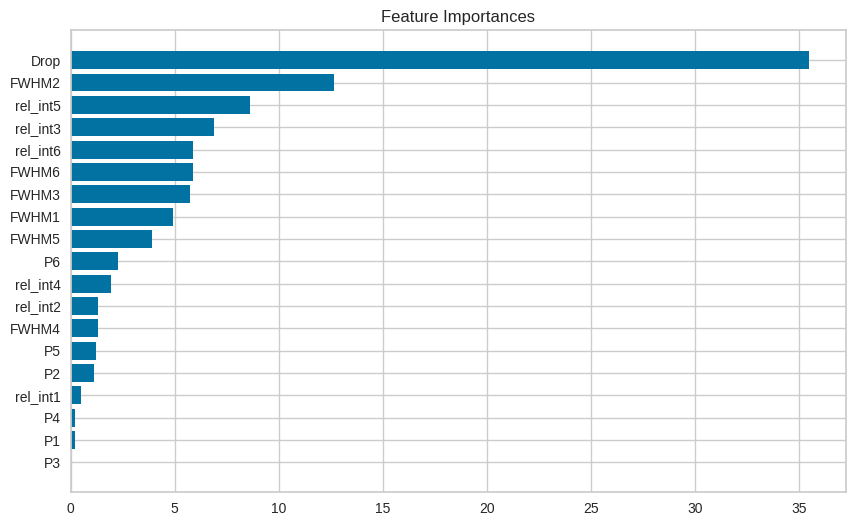

In [44]:
#optuna_CatBoostRegressor_changeable
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200,500),
        'depth': trial.suggest_int('depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.07),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 10)
    }

    model = CatBoostRegressor(**params,silent=True)

    kf = KFold(n_splits=3, shuffle=True, random_state=78)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
    return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)


cbr_best_params = study.best_params
print(f"Best hyperparameters: {cbr_best_params}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
cbr_XRD = CatBoostRegressor(**cbr_best_params,silent=True)
cbr_XRD.fit(X_train, y_train)


#feature importances
feature_importances = cbr_XRD.feature_importances_
feature_names = X.columns.tolist()
indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [45]:
Cat2 = metrics(cbr_XRD,'CatBoostRegressor')
Cat2

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
CatBoostRegressor,0.833277,0.853063,0.084155,0.069715,0.290094,0.264035


In [46]:
cross_validation(3,78,cbr_XRD)

Cross-validated R2(Train): 0.11881405254013862


In [47]:
adjusted_r2(cbr_XRD)

Adjusted_R2: 0.4471130905982469
Adjusted_R2_train: -1.938746466640001
Adjusted_R2_test: 1.0595439192547156


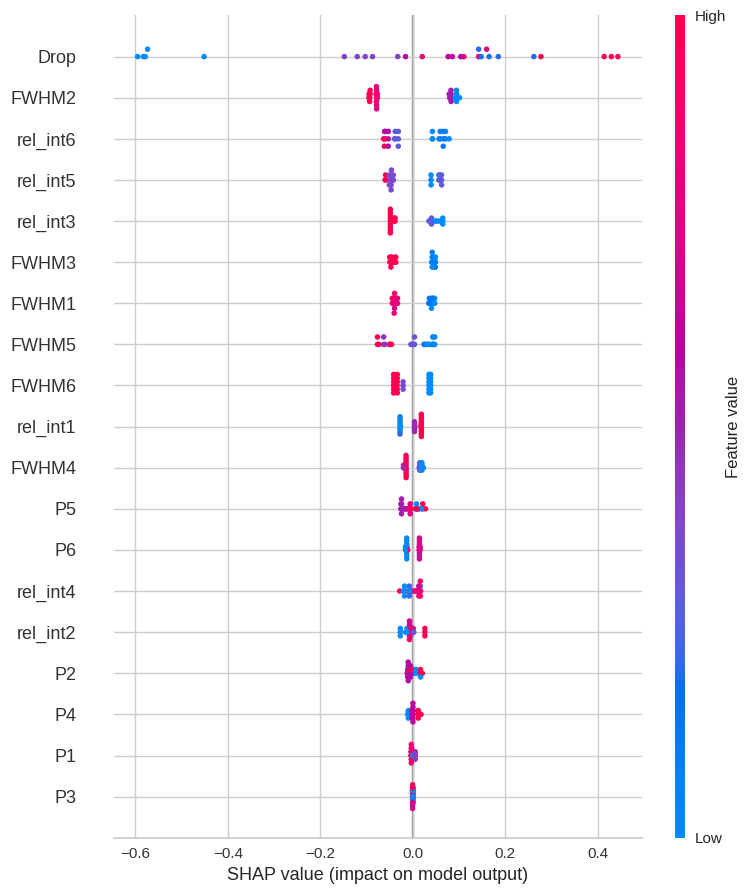

In [48]:
Shap(cbr_XRD)

###GradientBoostingRegressor

In [ ]:
#Optimization_Gradient Boosting Regressor
def objective(learning_rate, n_estimators, subsample,min_samples_split):
    model = GradientBoostingRegressor(learning_rate=learning_rate,
                         n_estimators=int(n_estimators),
                         subsample=subsample,
                         min_samples_split=int(min_samples_split))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)
#===============================================================================
pbounds = {
    'learning_rate': (0.03, 0.035),
    'n_estimators': (265,265),
    'subsample': (0.97, 0.99),
    'min_samples_split' : (8,8)
}
#===============================================================================
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=78,
)

optimizer.maximize(
    init_points=5,
    n_iter=30,
)

In [49]:
model_GBR_XRD = GradientBoostingRegressor(n_estimators=337, learning_rate=0.03011, subsample=0.9886,min_samples_split=9,random_state=78)
model_GBR_XRD.fit(X_train, y_train);
GBR1 = metrics(model_GBR_XRD,'GradientBoostingRegressor')
GBR1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
GradientBoostingRegressor,0.914161,0.917909,0.043328,0.038948,0.208154,0.197353


In [50]:
cross_validation(3,78,model_GBR_XRD)

Cross-validated R2(Train): -0.32351282982095814


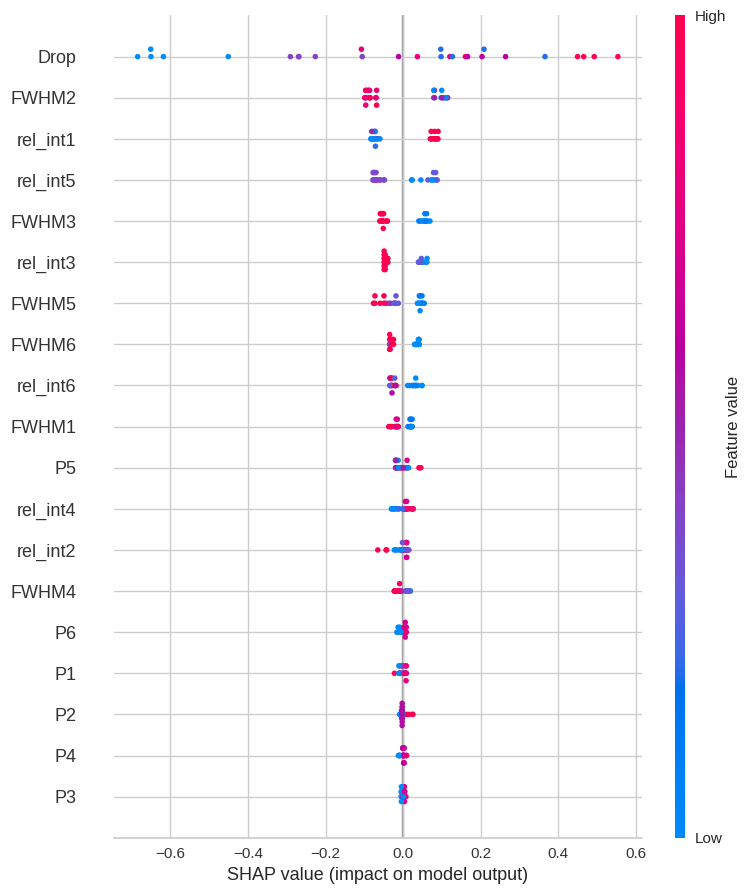

In [51]:
Shap(model_GBR_XRD)

#PL

In [52]:
Paper1_PL = pd.read_excel('/content/data_paper1.xlsx',sheet_name='PL')
X = Paper1_PL.drop('delta(eff)', axis=1)
y = Paper1_PL['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

###XGBoostRegressor

In [53]:
model_XGB_PL = XGBRegressor(alpha=0.02752, reg_lambda=0.9295, n_estimators=315, learning_rate= 0.04316)
model_XGB_PL.fit(X_train, y_train);
XGB_PL1 = metrics(model_XGB_PL,'XGBoostRegressor')
XGB_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.952466,0.958986,0.023993,0.019459,0.154898,0.139496


In [54]:
adjusted_r2(model_XGB_PL)

Adjusted_R2: 0.9396550956604939
Adjusted_R2_train: 0.9316438124213932
Adjusted_R2_test: 1.0792238429005816


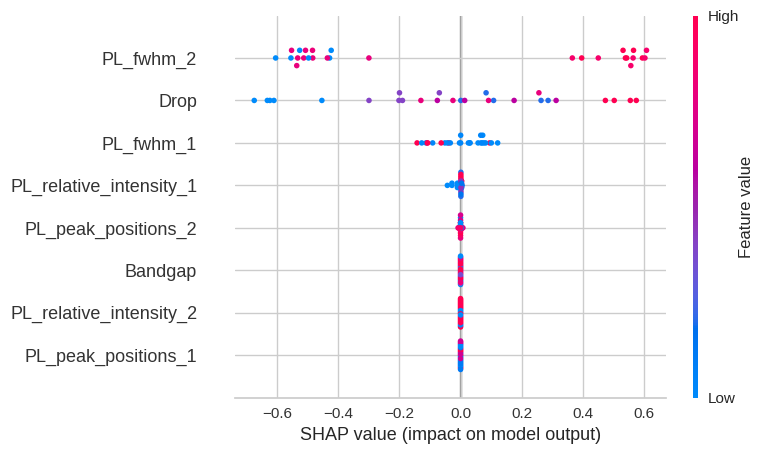

In [55]:
Shap(model_XGB_PL)



---



---



[I 2024-07-06 23:05:51,568] A new study created in memory with name: no-name-cbd81aa0-793d-4fb8-9a53-56beac3123a4
[I 2024-07-06 23:05:51,789] Trial 0 finished with value: 0.3442301643410575 and parameters: {'alpha': 0.3594637262295042, 'reg_lambda': 0.8789297619910547, 'n_estimators': 421, 'learning_rate': 0.3771005928496739}. Best is trial 0 with value: 0.3442301643410575.
[I 2024-07-06 23:05:51,990] Trial 1 finished with value: 0.3469778200556706 and parameters: {'alpha': 0.33317744845322755, 'reg_lambda': 0.8997647008197307, 'n_estimators': 339, 'learning_rate': 0.3285475949155202}. Best is trial 0 with value: 0.3442301643410575.
[I 2024-07-06 23:05:52,201] Trial 2 finished with value: 0.34592069950915033 and parameters: {'alpha': 0.3376780929983005, 'reg_lambda': 0.8133082800631478, 'n_estimators': 368, 'learning_rate': 0.3754752643272564}. Best is trial 0 with value: 0.3442301643410575.
[I 2024-07-06 23:05:52,423] Trial 3 finished with value: 0.35013917971605807 and parameters: {'

{'alpha': 0.3488372091854022, 'reg_lambda': 0.8040790678142903, 'n_estimators': 412, 'learning_rate': 0.3165558111288921}


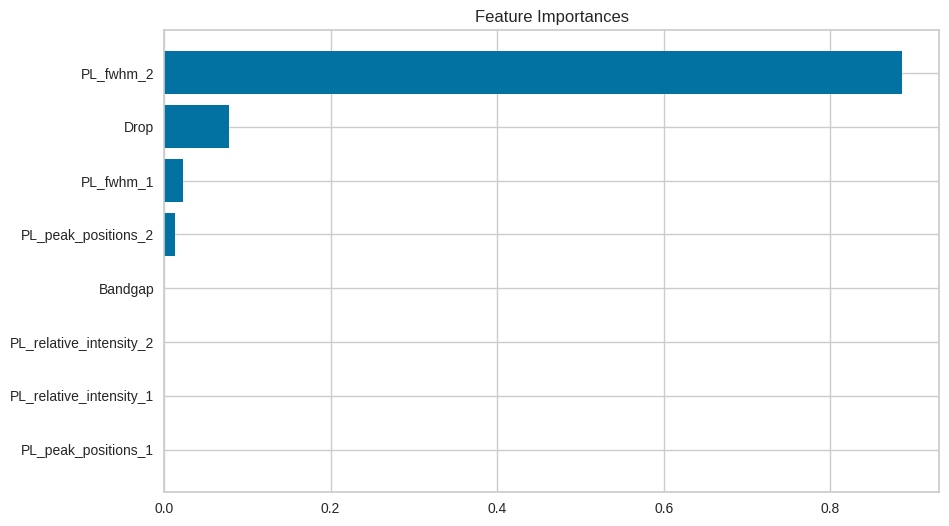

In [56]:
#optuna_XGBoostRegressor_changeable
def objective(trial):
  params = {
      'alpha': trial.suggest_float('alpha', 0.3, 0.4),
      'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 0.9),
      'n_estimators': trial.suggest_int('n_estimators', 300,500),
      'learning_rate': trial.suggest_float('learning_rate', 0.3, 0.4),
      }

  model = XGBRegressor(**params)
  kf = KFold(n_splits=3, shuffle=True, random_state=78)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
  return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

xgb_best_params = study.best_params
print(xgb_best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
xgb_PL = XGBRegressor(**xgb_best_params)
xgb_PL.fit(X_train, y_train)


#feature importances
feature_importances = xgb_PL.feature_importances_
feature_names = X.columns.tolist()

indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [57]:
XGB_PL2 = metrics(xgb_PL,'XGBoostRegressor')
XGB_PL2

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.832237,0.870744,0.08468,0.061326,0.290998,0.247641


In [58]:
adjusted_r2(xgb_PL)

Adjusted_R2: 0.8038822010339436
Adjusted_R2_train: 0.7845729758233119
Adjusted_R2_test: 1.2796043258701737


###RandomForestRegressor

[I 2024-07-06 23:06:32,646] A new study created in memory with name: no-name-28cba7d9-b0e8-43d5-9dc5-d6d62acb0510
[I 2024-07-06 23:06:36,426] Trial 0 finished with value: 0.3423404465797744 and parameters: {'n_estimators': 721, 'max_depth': 10}. Best is trial 0 with value: 0.3423404465797744.
[I 2024-07-06 23:06:39,107] Trial 1 finished with value: 0.34108447643288065 and parameters: {'n_estimators': 735, 'max_depth': 8}. Best is trial 1 with value: 0.34108447643288065.
[I 2024-07-06 23:06:41,930] Trial 2 finished with value: 0.34551045480063997 and parameters: {'n_estimators': 785, 'max_depth': 8}. Best is trial 1 with value: 0.34108447643288065.
[I 2024-07-06 23:06:45,075] Trial 3 finished with value: 0.3440595804921281 and parameters: {'n_estimators': 875, 'max_depth': 7}. Best is trial 1 with value: 0.34108447643288065.
[I 2024-07-06 23:06:48,812] Trial 4 finished with value: 0.3390209012748277 and parameters: {'n_estimators': 740, 'max_depth': 8}. Best is trial 4 with value: 0.339

{'n_estimators': 740, 'max_depth': 8}


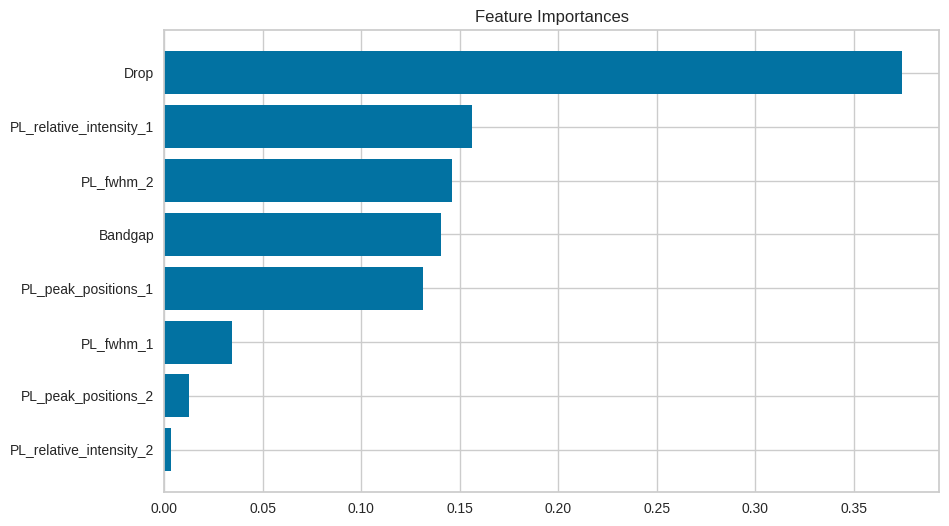

In [62]:
#optuna_RandomForestRegressor_changeable
def objective(trial):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 700,900),
      'max_depth': trial.suggest_int('max_depth', 7,10),
      }

  model = RandomForestRegressor(**params)
  kf = KFold(n_splits=3, shuffle=True, random_state=78)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
  return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

RF_best_params = study.best_params
print(RF_best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
RF_PL = RandomForestRegressor(**RF_best_params)
RF_PL.fit(X_train, y_train)


#feature importances
feature_importances = RF_PL.feature_importances_
feature_names = X.columns.tolist()
indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [63]:
RF_PL1 = metrics(RF_PL,'RandomForestRegressor')
RF_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
RandomForestRegressor,0.857555,0.901781,0.0719,0.0466,0.268143,0.21587


In [64]:
adjusted_r2(RF_PL)

Adjusted_R2: 0.8460250493376154
Adjusted_R2_train: 0.8363021862898786
Adjusted_R2_test: 1.2374086960438875


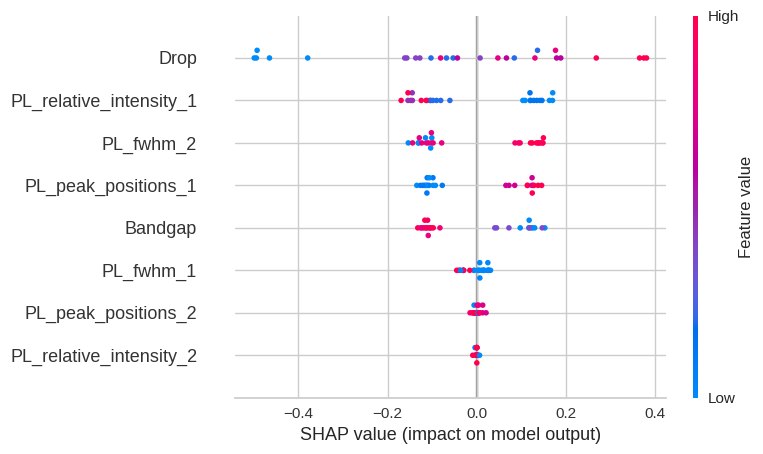

In [65]:
Shap(RF_PL)

###CatboostRegressor

In [66]:
model_Cat_PL = CatBoostRegressor(iterations=172, depth=3, learning_rate=0.07545457620773927, l2_leaf_reg=3.0671713060927353,verbose=0)
model_Cat_PL.fit(X_train, y_train);
Cat_PL1 = metrics(model_Cat_PL,'CatBoostRegressor')
Cat_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
CatBoostRegressor,0.82457,0.90948,0.08855,0.042948,0.297573,0.207238


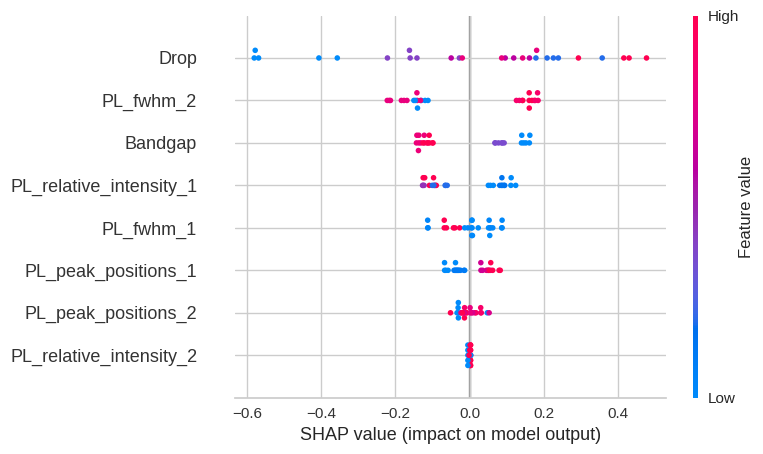

In [67]:
Shap(model_Cat_PL)

[I 2024-07-06 23:07:03,513] A new study created in memory with name: no-name-7bdc14f6-8963-44fb-bae3-5b5164833098
[I 2024-07-06 23:07:03,693] Trial 0 finished with value: 0.04444430253464582 and parameters: {'iterations': 263, 'depth': 3, 'learning_rate': 0.04629775438289582, 'l2_leaf_reg': 6.47629144442846}. Best is trial 0 with value: 0.04444430253464582.
[I 2024-07-06 23:07:03,942] Trial 1 finished with value: 0.09341850839398251 and parameters: {'iterations': 430, 'depth': 3, 'learning_rate': 0.04087442597240906, 'l2_leaf_reg': 9.316993287203452}. Best is trial 0 with value: 0.04444430253464582.
[I 2024-07-06 23:07:04,203] Trial 2 finished with value: 0.06340063695927607 and parameters: {'iterations': 363, 'depth': 4, 'learning_rate': 0.0414713248226079, 'l2_leaf_reg': 2.2737366827968613}. Best is trial 0 with value: 0.04444430253464582.
[I 2024-07-06 23:07:04,422] Trial 3 finished with value: 0.11226192006064288 and parameters: {'iterations': 246, 'depth': 5, 'learning_rate': 0.04

Best hyperparameters: {'iterations': 263, 'depth': 3, 'learning_rate': 0.04629775438289582, 'l2_leaf_reg': 6.47629144442846}


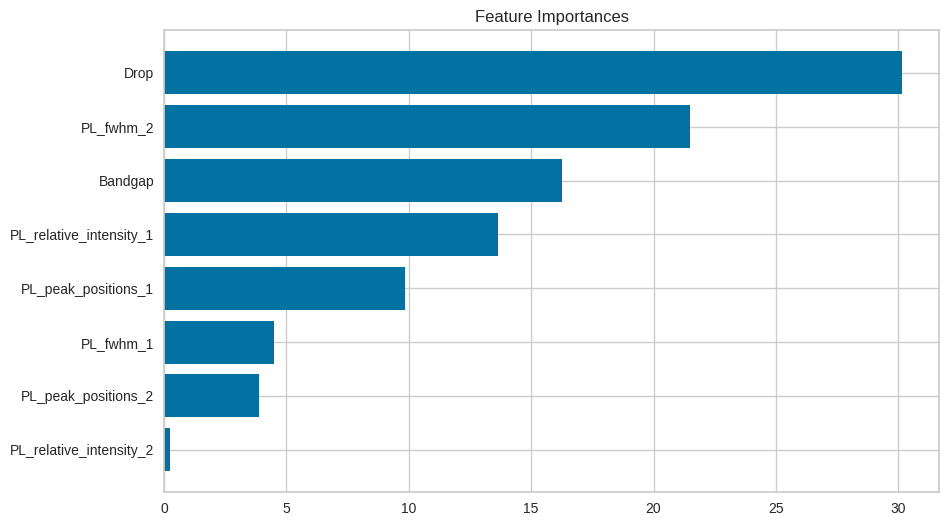

In [68]:
#optuna_CatBoostRegressor_changeable
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200,500),
        'depth': trial.suggest_int('depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.05),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 10)
    }

    model = CatBoostRegressor(**params,silent=True)

    kf = KFold(n_splits=2, shuffle=True, random_state=78)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
    return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)


cbr_best_params = study.best_params
print(f"Best hyperparameters: {cbr_best_params}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)


cbr_PL = CatBoostRegressor(**cbr_best_params,silent=True)
cbr_PL.fit(X_train, y_train)



#feature importances
feature_importances = cbr_PL.feature_importances_
feature_names = X.columns.tolist()
indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [69]:
Cat_PL2 = metrics(cbr_PL,'CatBoostRegressor')
Cat_PL2

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
CatBoostRegressor,0.853818,0.864334,0.073786,0.064367,0.271637,0.253707


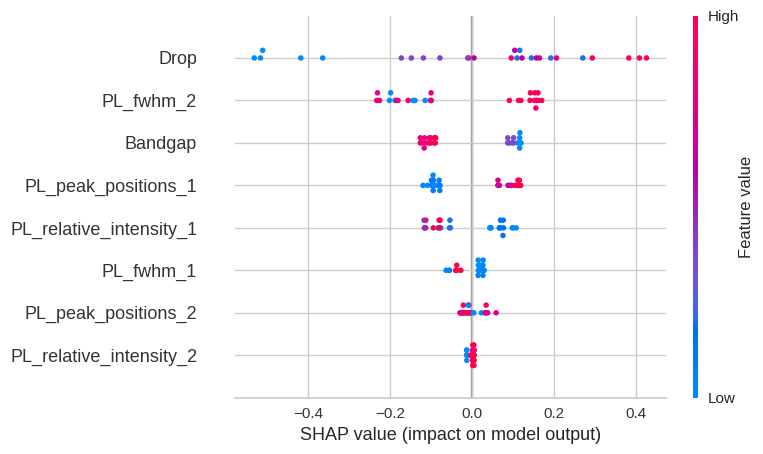

In [70]:
Shap(cbr_PL)

###GradinetBoostingRegressor

In [71]:
model_GBR_PL = GradientBoostingRegressor(n_estimators=337, learning_rate=0.03011, subsample=0.9886,min_samples_split=9,random_state=78)
model_GBR_PL.fit(X_train, y_train);
GBR_PL1 = metrics(model_GBR_PL,'GradientBoostingRegressor')
GBR_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
GradientBoostingRegressor,0.901013,0.919836,0.049965,0.038034,0.223528,0.195023


In [73]:
adjusted_r2(model_GBR_PL)

Adjusted_R2: 0.8800420794477645
Adjusted_R2_train: 0.8663940475391859
Adjusted_R2_test: 1.16497904808118


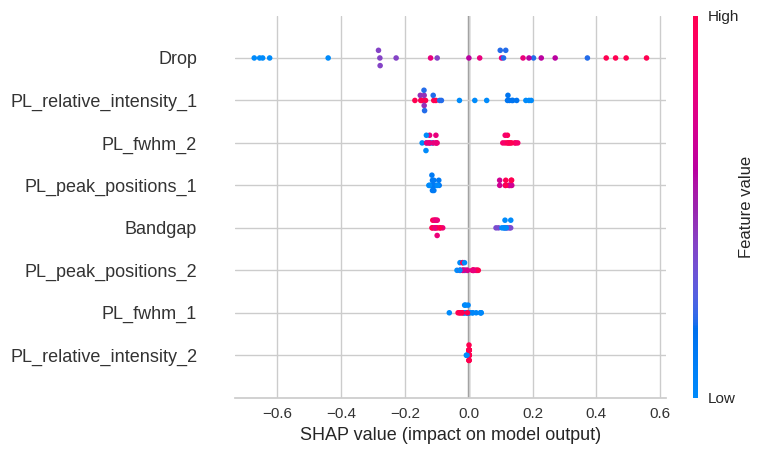

In [72]:
Shap(model_GBR_PL)

#XRD+PL

In [74]:
Paper1_XRD_PL = pd.read_excel('/content/data_paper1.xlsx',sheet_name='XRD+PL')
X = Paper1_XRD_PL.drop(columns=['delta(eff)'])
y = Paper1_XRD_PL['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

##Models

###XGBoostRegressor

In [75]:
model_XGB_XRD_PL = XGBRegressor(alpha=0.02752, reg_lambda=0.9295, n_estimators=315, learning_rate= 0.04316)
model_XGB_XRD_PL .fit(X_train, y_train);
XGB_XRD_PL1 = metrics(model_XGB_XRD_PL, 'XGBoostRegressor')
XGB_XRD_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.960617,0.969028,0.019879,0.014695,0.140993,0.121221


[I 2024-07-06 23:07:49,256] A new study created in memory with name: no-name-94ac4418-a310-45f9-96ff-acb2eca59209
[I 2024-07-06 23:07:49,515] Trial 0 finished with value: 0.4907903125999039 and parameters: {'alpha': 0.07433532698925138, 'reg_lambda': 0.8005895775118447, 'n_estimators': 402, 'learning_rate': 0.041587051928897105}. Best is trial 0 with value: 0.4907903125999039.
[I 2024-07-06 23:07:49,759] Trial 1 finished with value: 0.47921940962503107 and parameters: {'alpha': 0.09042383154215893, 'reg_lambda': 0.906521388846779, 'n_estimators': 376, 'learning_rate': 0.0160771712851703}. Best is trial 1 with value: 0.47921940962503107.
[I 2024-07-06 23:07:50,015] Trial 2 finished with value: 0.488017258888498 and parameters: {'alpha': 0.06583447783184913, 'reg_lambda': 0.9216652831438733, 'n_estimators': 329, 'learning_rate': 0.02931793774175087}. Best is trial 1 with value: 0.47921940962503107.
[I 2024-07-06 23:07:50,201] Trial 3 finished with value: 0.4860755157701334 and parameters

{'alpha': 0.09042383154215893, 'reg_lambda': 0.906521388846779, 'n_estimators': 376, 'learning_rate': 0.0160771712851703}


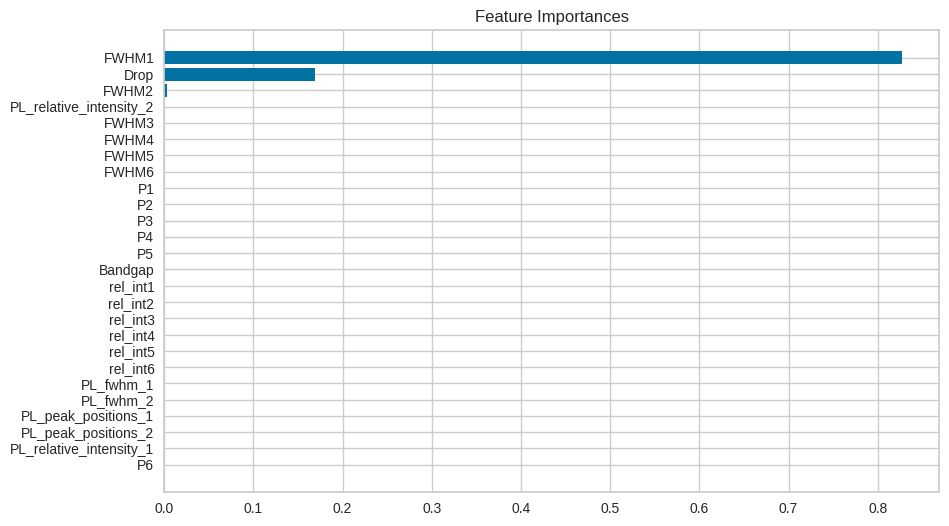

In [76]:
#optuna_XGBoostRegressor_changeable
def objective(trial):
  params = {
      'alpha': trial.suggest_float('alpha', 0.02, 0.1),
      'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 0.95),
      'n_estimators': trial.suggest_int('n_estimators', 200,500),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
      }

  model = XGBRegressor(**params)
  kf = KFold(n_splits=2, shuffle=True, random_state=78)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
  return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

xgb_best_params = study.best_params
print(xgb_best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
xgb_XRD_PL = XGBRegressor(**xgb_best_params)
xgb_XRD_PL.fit(X_train, y_train)

#feature importances
feature_importances = xgb_XRD_PL.feature_importances_
feature_names = X.columns.tolist()
indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [77]:
XGB_XRD_PL2 = metrics(xgb_XRD_PL,'XGBoostRegressor')
XGB_XRD_PL2

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.87034,0.892899,0.065447,0.050814,0.255826,0.22542


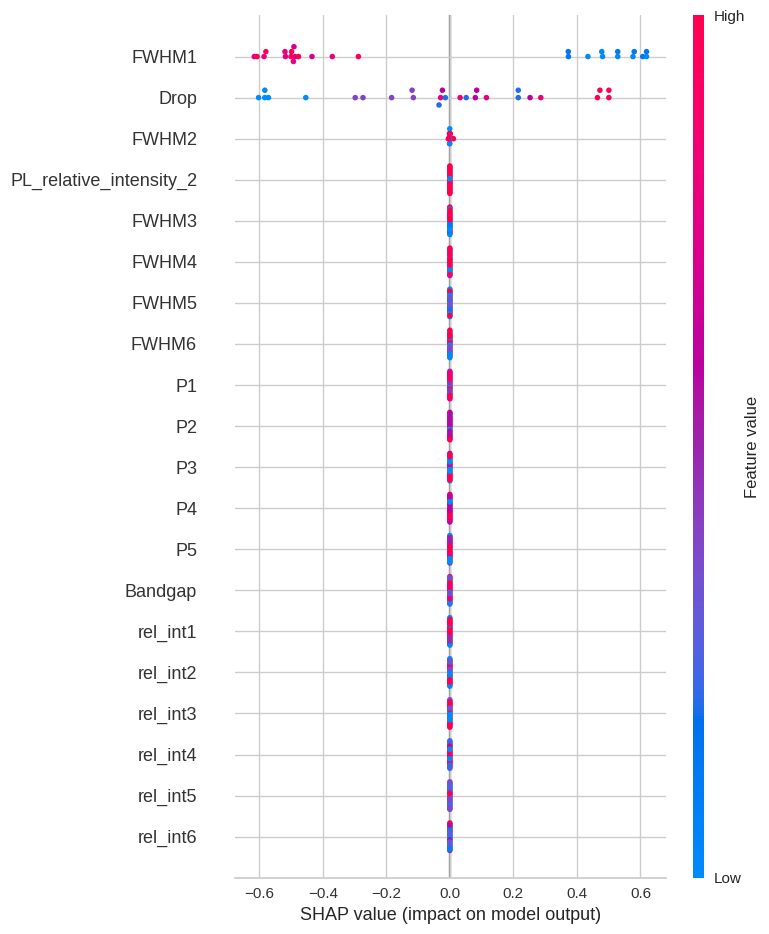

In [78]:
Shap(xgb_XRD_PL)

###RandomForestRegressor

[I 2024-07-06 23:09:36,246] A new study created in memory with name: no-name-e63c7cfd-3d53-4287-a049-7746876d262b
[I 2024-07-06 23:09:41,163] Trial 0 finished with value: 0.426358305106134 and parameters: {'n_estimators': 758, 'max_depth': 10}. Best is trial 0 with value: 0.426358305106134.
[I 2024-07-06 23:09:46,188] Trial 1 finished with value: 0.42656638382168577 and parameters: {'n_estimators': 809, 'max_depth': 7}. Best is trial 0 with value: 0.426358305106134.
[I 2024-07-06 23:09:52,418] Trial 2 finished with value: 0.42740661976137756 and parameters: {'n_estimators': 815, 'max_depth': 8}. Best is trial 0 with value: 0.426358305106134.
[I 2024-07-06 23:09:57,614] Trial 3 finished with value: 0.4185336104527309 and parameters: {'n_estimators': 848, 'max_depth': 9}. Best is trial 3 with value: 0.4185336104527309.
[I 2024-07-06 23:10:04,550] Trial 4 finished with value: 0.41977623032839534 and parameters: {'n_estimators': 900, 'max_depth': 8}. Best is trial 3 with value: 0.418533610

{'n_estimators': 848, 'max_depth': 9}


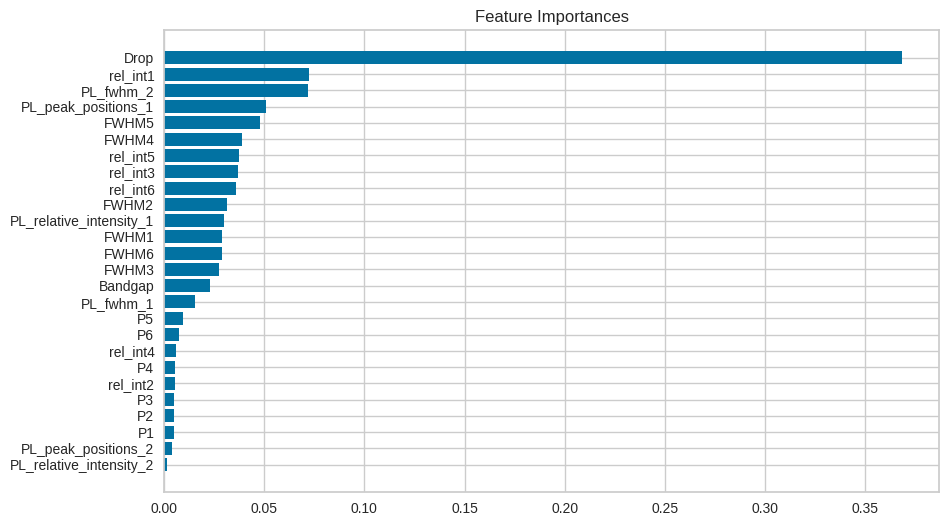

In [81]:
#optuna_RandomForestRegressor_changeable
def objective(trial):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 700,900),
      'max_depth': trial.suggest_int('max_depth', 7,10),
      }

  model = RandomForestRegressor(**params)
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
  return -cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

RF_best_params = study.best_params
print(RF_best_params)


RF_XRD_PL = RandomForestRegressor(**RF_best_params)
RF_XRD_PL.fit(X_train, y_train)



#feature importances
feature_importances = RF_XRD_PL.feature_importances_
feature_names = X.columns.tolist()
indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [82]:
RF_XRD_PL1 = metrics(RF_XRD_PL,'RandomForestRegressor')
RF_XRD_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
RandomForestRegressor,0.852647,0.898793,0.074378,0.048018,0.272723,0.21913


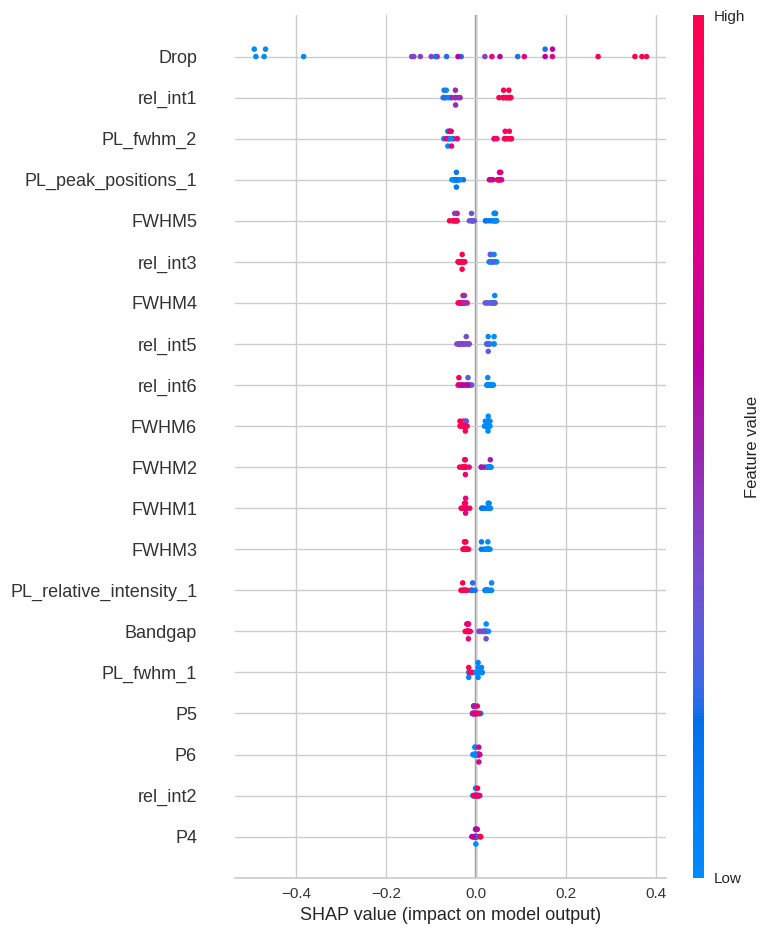

In [83]:
Shap(RF_XRD_PL)

###CatBoostRegressor

In [84]:
model_Cat_XRD_PL = CatBoostRegressor(iterations=172, depth=3, learning_rate=0.07545457620773927, l2_leaf_reg=3.0671713060927353,verbose=0)
model_Cat_XRD_PL.fit(X_train, y_train);
Cat_XRD_PL1 = metrics(model_Cat_XRD_PL,'CatBoostRegressor')
Cat_XRD_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
CatBoostRegressor,0.882923,0.896712,0.059096,0.049005,0.243096,0.221371


In [85]:
cross_validation(3,78,model_Cat_XRD_PL)

Cross-validated R2(Train): 0.18993078296197818


In [86]:
adjusted_r2(model_Cat_XRD_PL)

Adjusted_R2: -inf
Adjusted_R2_train: 1.3442932880268068
Adjusted_R2_test: 1.0278754775915835


<ipython-input-6-f34df6560a3f>:2: RuntimeWarning: divide by zero encountered in scalar divide
  adjusted_r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)


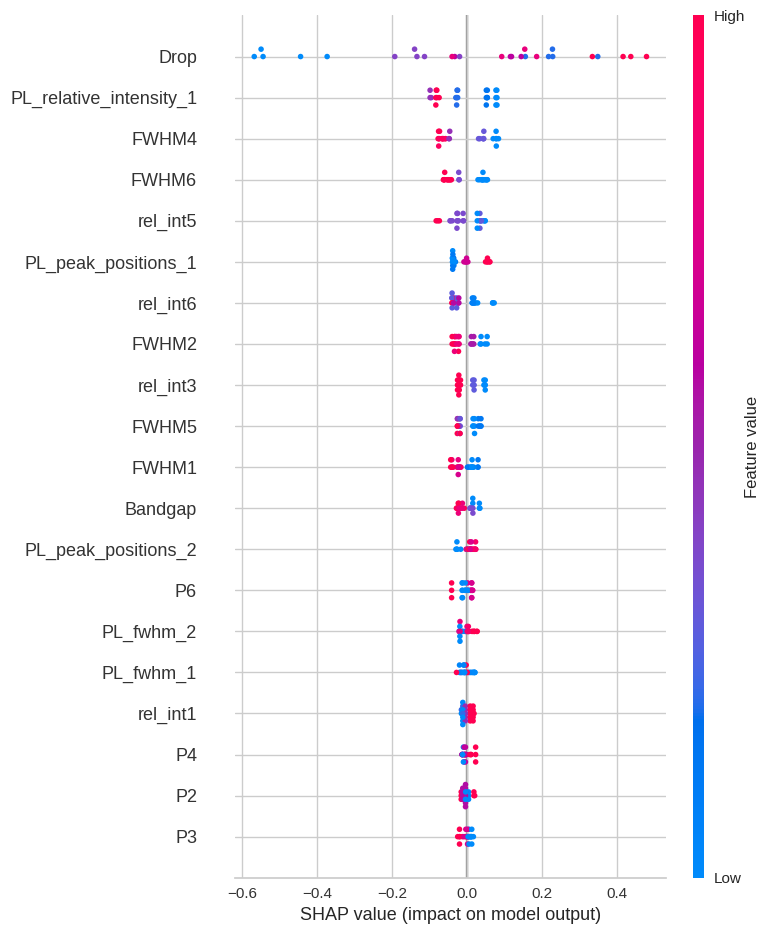

In [87]:
Shap(model_Cat_XRD_PL)

[I 2024-07-06 23:13:25,972] A new study created in memory with name: no-name-6e399eff-4808-48c4-bfd4-c90a38357897
[I 2024-07-06 23:13:26,491] Trial 0 finished with value: 0.09873896626224521 and parameters: {'iterations': 828, 'depth': 4, 'learning_rate': 0.023081488224586062, 'l2_leaf_reg': 2.4051920453567863}. Best is trial 0 with value: 0.09873896626224521.
[I 2024-07-06 23:13:26,595] Trial 1 finished with value: 0.25609228857613103 and parameters: {'iterations': 195, 'depth': 1, 'learning_rate': 0.014576778500504293, 'l2_leaf_reg': 3.7572375975315895}. Best is trial 0 with value: 0.09873896626224521.
[I 2024-07-06 23:13:26,711] Trial 2 finished with value: 0.17086305179100125 and parameters: {'iterations': 82, 'depth': 4, 'learning_rate': 0.029960376067246948, 'l2_leaf_reg': 5.564347930496159}. Best is trial 0 with value: 0.09873896626224521.
[I 2024-07-06 23:13:26,820] Trial 3 finished with value: 0.20175748523650738 and parameters: {'iterations': 87, 'depth': 3, 'learning_rate': 

Best hyperparameters: {'iterations': 697, 'depth': 3, 'learning_rate': 0.022438786330276336, 'l2_leaf_reg': 3.753465551589686}
Feature Importances:
Drop: 34.949
FWHM1: 3.424
FWHM2: 4.846
FWHM3: 3.386
FWHM4: 5.513
FWHM5: 2.199
FWHM6: 4.467
P1: 0.740
P2: 1.438
P3: 0.512
P4: 0.473
P5: 1.871
P6: 1.175
rel_int1: 3.406
rel_int2: 0.791
rel_int3: 5.800
rel_int4: 1.144
rel_int5: 2.450
rel_int6: 4.286
PL_fwhm_1: 0.920
PL_fwhm_2: 3.124
PL_peak_positions_1: 4.011
PL_peak_positions_2: 0.902
PL_relative_intensity_1: 5.081
PL_relative_intensity_2: 0.222
Bandgap: 2.867


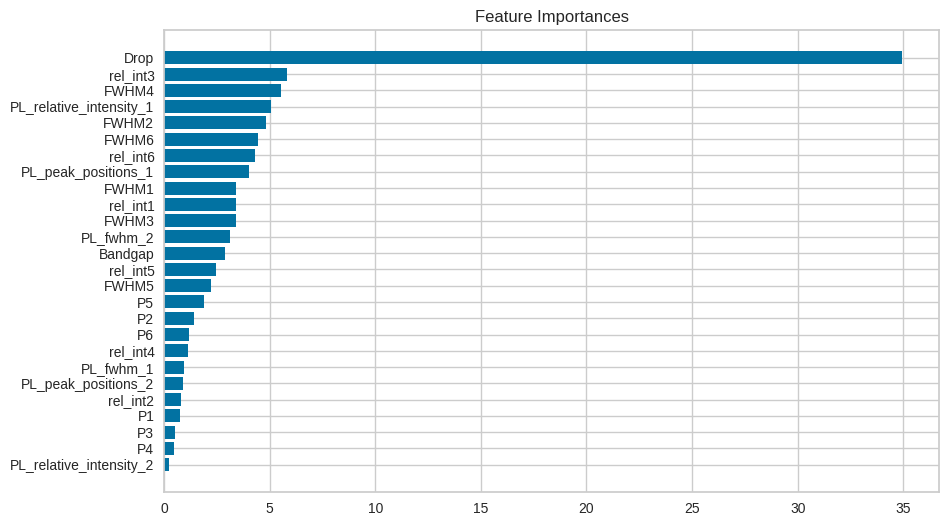

In [101]:
#optuna_CatBoostRegrssor_changeable
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'depth': trial.suggest_int('depth', 1, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 10)
    }


    model = CatBoostRegressor(**params,silent=True)

    kf = KFold(n_splits=2, shuffle=True, random_state=78)
    cv_scores = cross_val_score(model, X_train, y_train, cv=2, scoring='r2')
    return cv_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)


cbr_best_params = study.best_params
print(f"Best hyperparameters: {cbr_best_params}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
cbr_XRD_PL = CatBoostRegressor(**cbr_best_params,silent=True)
cbr_XRD_PL.fit(X_train, y_train)


#feature importances
feature_importances = cbr_XRD_PL.feature_importances_
feature_names = X.columns.tolist()
print("Feature Importances:")
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance:.3f}")

indices = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [102]:
Cat_XRD_PL2 = metrics(cbr_XRD_PL,'CatBoostRegressor')
Cat_XRD_PL2

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
CatBoostRegressor,0.857193,0.914238,0.072083,0.04069,0.268483,0.201717


In [104]:
cross_validation(3,78,cbr_XRD_PL)

Cross-validated R2(Train): 0.20293245656086364


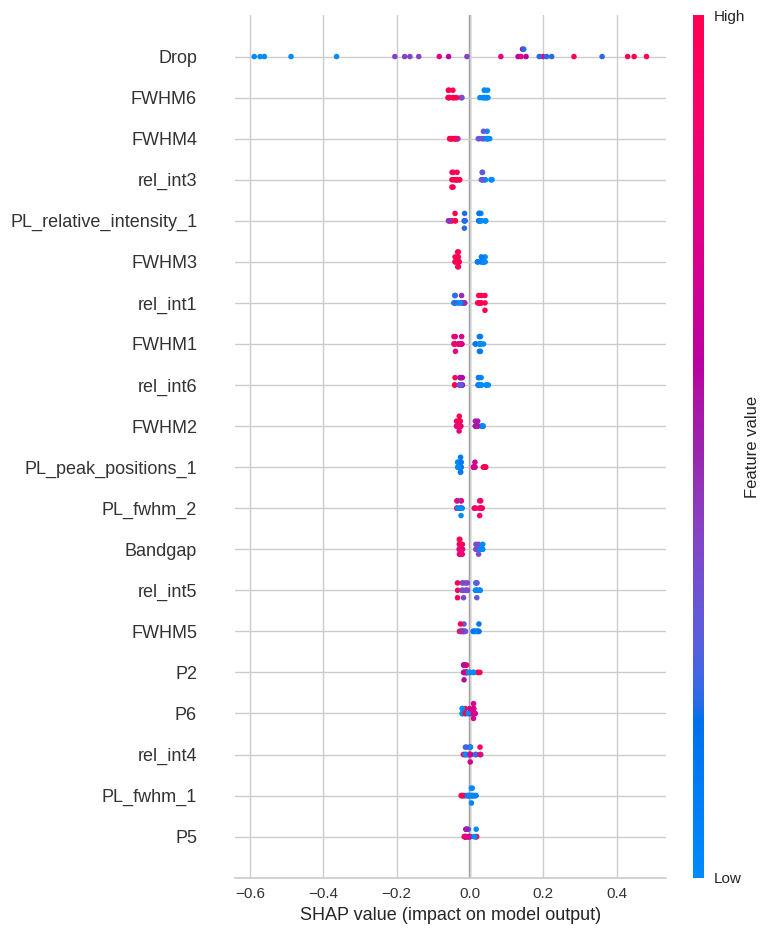

In [103]:
Shap(cbr_XRD_PL)

###GradientBoostingRegressor

In [105]:
model_GBR_XRD_PL = GradientBoostingRegressor(n_estimators=337, learning_rate=0.03011, subsample=0.9886,min_samples_split=9,random_state=78)
model_GBR_XRD_PL.fit(X_train, y_train);
GBR_XRD_PL1 = metrics(model_GBR_XRD_PL,'GradientBoostingRegressor')
GBR_XRD_PL1

,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
GradientBoostingRegressor,0.914161,0.917909,0.043328,0.038948,0.208154,0.197353


In [108]:
cross_validation(2,78,model_GBR_XRD_PL)

Cross-validated R2(Train): 0.28500019440167934


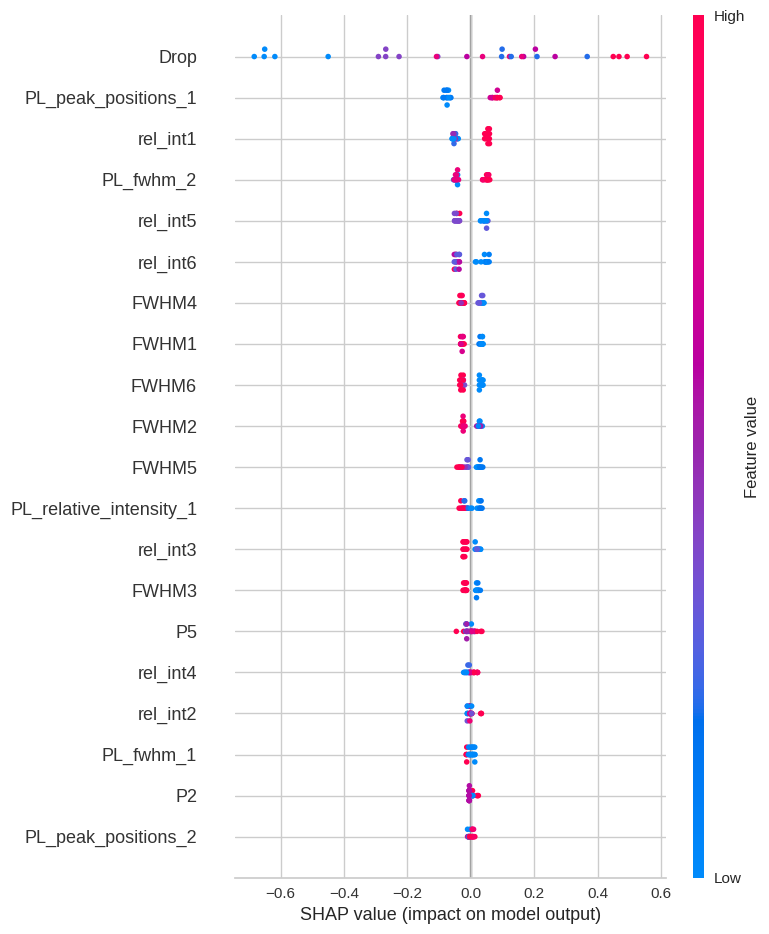

In [106]:
Shap(model_GBR_XRD_PL)



---



---



#Results

In [127]:
print('\033[91m''XRD Models Results''\033[0m')

result_XRD = pd.concat([XGB1, XGB2,RF1,Cat1,Cat2,GBR1])
result_XRD

XRD Models Results


,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.960617,0.969028,0.019879,0.014695,0.140993,0.121221
XGBoostRegressor,0.819482,0.827770,0.091118,0.081715,0.301858,0.285858
RandomForestregressor,0.852709,0.895121,0.074347,0.049760,0.272666,0.223070
CatBoostRegressor,0.850673,0.902093,0.075374,0.046452,0.274544,0.215527
CatBoostRegressor,0.833277,0.853063,0.084155,0.069715,0.290094,0.264035
GradientBoostingRegressor,0.914161,0.917909,0.043328,0.038948,0.208154,0.197353


In [128]:
print('\033[91m''PL Models Results''\033[0m')

result_PL = pd.concat([XGB_PL1, XGB_PL2, RF_PL1,Cat_PL1,Cat_PL2,GBR_PL1])
result_PL

PL Models Results


,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.952466,0.958986,0.023993,0.019459,0.154898,0.139496
XGBoostRegressor,0.832237,0.870744,0.084680,0.061326,0.290998,0.247641
RandomForestRegressor,0.857555,0.901781,0.071900,0.046600,0.268143,0.215870
CatBoostRegressor,0.824570,0.909480,0.088550,0.042948,0.297573,0.207238
CatBoostRegressor,0.853818,0.864334,0.073786,0.064367,0.271637,0.253707
GradientBoostingRegressor,0.901013,0.919836,0.049965,0.038034,0.223528,0.195023


In [129]:
print('\033[91m''XRD+PL Models Results''\033[0m')

result_XRD_PL = pd.concat([XGB_XRD_PL1, XGB_XRD_PL2,RF_XRD_PL1,Cat_XRD_PL1,Cat_XRD_PL2,GBR_XRD_PL1 ])
result_XRD_PL

XRD+PL Models Results


,R2_test,R2_train,mse_test,mse_train,rmse_test,rmse_train
XGBoostRegressor,0.960617,0.969028,0.019879,0.014695,0.140993,0.121221
XGBoostRegressor,0.870340,0.892899,0.065447,0.050814,0.255826,0.225420
RandomForestRegressor,0.852647,0.898793,0.074378,0.048018,0.272723,0.219130
CatBoostRegressor,0.882923,0.896712,0.059096,0.049005,0.243096,0.221371
CatBoostRegressor,0.857193,0.914238,0.072083,0.040690,0.268483,0.201717
GradientBoostingRegressor,0.914161,0.917909,0.043328,0.038948,0.208154,0.197353
